<img src="starbucks.png" style="height: 250px">

# Starbucks Capstone Challenge

# 1. Introduction

<a id="Overview"></a>
## Project Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 


<a id="#problem-statement"></a>
## Problem Statement
The purpose of this project is to aggregate transaction, demographic, and offer data to see which demographic groups respond best to different types of offers.
Because the underlying simulator only contains one product, although Starbucks sells hundreds, this data set is a simplified version of the real Starbucks app. 

## Metrics

Because the goal of the project is to create a classification model, I chose accuracy and F1 score as model evaluation metrics.

The reason I chose both metrics is that when the dataset is imbalanced, accuracy alone cannot objectively show how the model is performing on the dataset, whereas F1 score provides a better sense of model performance than accuracy alone because it accounts for both false positives and false negatives.
When the class distribution is skewed, F1 may be more useful than accuracy. 

<a id="#Datasets"></a>
## Datasets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

---

# 2. Explanatory Data Analysis

<a id="#Load-Packages"></a>
## Load Packages

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
print('Done!')

Done!


<a id="#Load-"></a>
## Load Datasets

In [2]:
# Read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Have an idea of the datasets shapes
print(portfolio.shape)
print(profile.shape)
print(transcript.shape)


(10, 6)
(17000, 5)
(306534, 4)


In this section, I will examine the problem and prepare the necessary features.
Investigating the datasets, which includes checking abnormalities or characteristics about the data, displaying the data distribution. 

## Portfolio: Data Exploration & Visualization 

### Explore Portfolio Dataset

- Check if the dataset has abnormalities (missing values, duplicates).
- Know more about the features' characteristics.
- Check the features' unique values 
- Display the features distribution.

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
# Checking if the dataset has abnormalities (missing values).
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

Luckily, there is no missing values in portfolio dataset.

In [5]:
# Checking if the dataset has abnormalities (duplicates).
portfolio.columns.duplicated().sum()

0

Luckily, there is no duplicate values in portfolio dataset.

In [6]:
# Know more about the features' characteristics.
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In the preprocceing section, I will convert these features (`channels`, `offer_type`, `id`) to the right data type. 

In [7]:
# Checking the features' unique values
print(portfolio[['difficulty', 'duration', 'id', 'offer_type', 'reward']].nunique())

difficulty     5
duration       5
id            10
offer_type     3
reward         5
dtype: int64


In [8]:
portfolio.describe().T.style

,count,mean,std,min,25%,50%,75%,max
reward,10.000000,4.200000,3.583915,0.000000,2.000000,4.000000,5.000000,10.000000
difficulty,10.000000,7.700000,5.831905,0.000000,5.000000,8.500000,10.000000,20.000000
duration,10.000000,6.500000,2.321398,3.000000,5.000000,7.000000,7.000000,10.000000


In [9]:
# Count of each data type
portfolio.dtypes.value_counts()

int64     3
object    3
dtype: int64

In [10]:
# Handy list of all the string/text columns in the dataset
list(portfolio.select_dtypes(include=object))

['channels', 'offer_type', 'id']

In [11]:
# Number of unique values in each column
print(portfolio[['difficulty', 'duration', 'id', 'offer_type', 'reward']].nunique())

difficulty     5
duration       5
id            10
offer_type     3
reward         5
dtype: int64


In [12]:
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

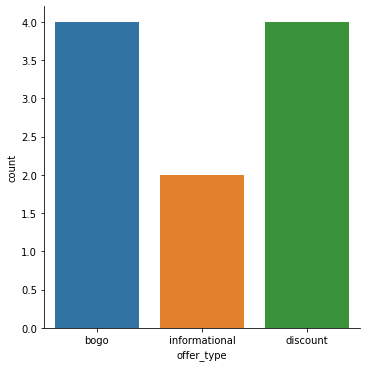

In [13]:
sns.catplot(x='offer_type', kind="count", data=portfolio,)

### The above exploration shows the following:
- The dataset has no missing values nor duplicates.
- There are three features that would require further work. 
- There are 10 unique offers and three unique offer types ('bogo', 'informational' and 'discount').  

## Portfolio: Data Preprocessing
- Work on the data type for these features (`channels`, `offer_type`, `id`).
    - On hot encoding `channels` features 
    - Convert the data type for these features (`offer_type`, `id`) to string.
    - Replace the categorical values to numrical for `offer_type`.
- Convert duration column unit to hours.  
- Drop `channels` column. 
- Show the cleaned dataset.

In [14]:
convert_dict = {'id': str,
                'offer_type': str
               }

In [15]:
# convert portfolio id and offer_type to string 
portfolio = portfolio.astype(convert_dict)

In [16]:
# Change the unit of 'duration' column from days to hours
portfolio['duration'] = portfolio['duration']*24

In [17]:
# Rename id and duration columns
portfolio.rename({'id': 'offer_id','duration':'duration_h'}, axis=1, inplace= True)

In [18]:
# Apply one hot encoding to channels column
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)

In [19]:
# Replace categorical variable to numeric in offer_type 
portfolio['offer_type'].replace(['bogo', 'informational','discount'],
                        [0, 1,2], inplace=True)

In [20]:
# Drop channels column
portfolio.drop(['channels'], axis=1, inplace=True)

In [21]:
# Cleaned Portfolio Dataset
portfolio.head()

,reward,difficulty,duration_h,offer_type,offer_id,web,email,mobile,social
0,10,10,168,0,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,120,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,96,1,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,168,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,240,2,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


## Profile: Data Exploration & Visualization 

### Explore Profile Dataset

- Check if the dataset has abnormalities (missing values, duplicates).
- Know more about the features' characteristics.
- Check the features' unique values 
- Display the features distribution.

In [22]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [23]:
# Checking if the dataset has abnormalities (missing values).
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

There are missing values in profile dataset that need to be investigated.

In [24]:
# Checking if the dataset has abnormalities (duplicates).
portfolio.columns.duplicated().sum()

0

Luckily, there is no duplicate values in portfolio dataset.

In [25]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In the preprocceing section, I will convert these features (`gender`, `became_member_on`, `id`) to the right format. 

In [26]:
profile.dtypes.value_counts()

object     2
int64      2
float64    1
dtype: int64

In [27]:
profile.describe().T.style

,count,mean,std,min,25%,50%,75%,max
age,17000.000000,62.531412,26.738580,18.000000,45.000000,58.000000,73.000000,118.000000
became_member_on,17000.000000,20167034.234118,11677.499961,20130729.000000,20160526.000000,20170802.000000,20171230.000000,20180726.000000
income,14825.000000,65404.991568,21598.299410,30000.000000,49000.000000,64000.000000,80000.000000,120000.000000


Here we can see that the max values for an age column is 118!

In [28]:
# Checking 118 age's records 
profile[profile['age']==118]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


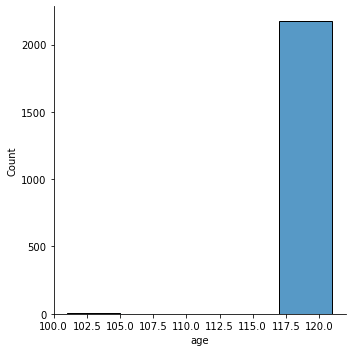

In [29]:
sns.displot(profile, x=profile[profile["age"]>100]['age'], binwidth=4)

In [30]:
profile.where(profile['age']==118).count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

All the missing values are associated with 118 age's records, for that I will drop each record with 118 age value in the preprocceing section 

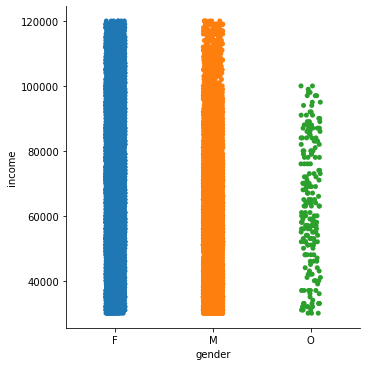

In [31]:
sns.catplot(x='gender', y='income',data=profile)

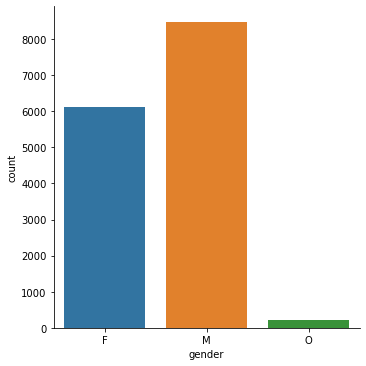

In [32]:
sns.catplot(x='gender', kind="count", data=profile)

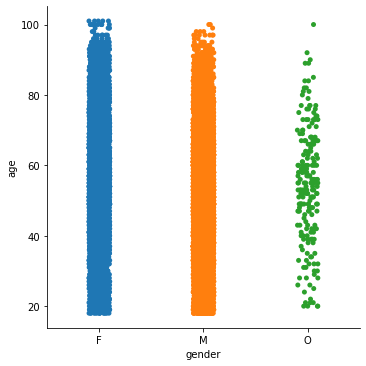

In [33]:
sns.catplot(x="gender", y="age", data=profile)

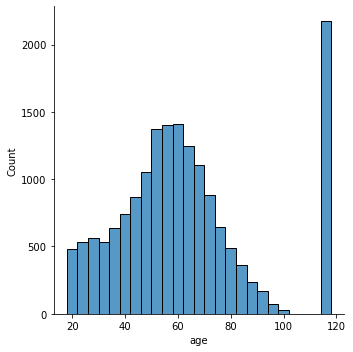

In [34]:
# Checking the distribution of 'age' column
sns.displot(profile, x=profile["age"], binwidth=4)

<AxesSubplot:xlabel='income', ylabel='Count'>

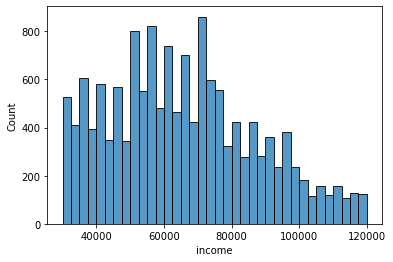

In [35]:
# Checking the distribution of 'income' column
sns.histplot(profile, x=profile["income"])

### The above exploration shows the following:
- The dataset has 2175 missing values and no duplicates.
- The distribution of `age` shows the follwoing:
    - The range of Starbuck customer age is (18 - 101).
    - The most customer age range is (45 - 65).
- The distribution of `income` shows the follwoing:
    - The range of Starbuck customer income is (30K - 120K).
    - The most custimer income range is (50K - 75K).
- There are three features that would require further work. 
- All the missing values related to one age value.

## Profile: Data Preprocessing
- Work on the data type for these features (`gender`, `became_member_on`, `id`). 
    - Rename `id` column to customer_id.
    - Replace `gender` categorical variable to numeric. 
    - Change `became_member_on` format to the right one (YYYY-MM-DD).
- Drop all rows with 118 `age` value.
- Show the cleaned dataset.

In [36]:
# Drop all rows with 118 age  
profile.drop(profile[profile['age'] == 118].index, inplace = True)

In [37]:
# Rename id column to customer_id
profile.rename({'id': 'customer_id'}, axis=1, inplace= True)

In [38]:
# Change became_member_on type to the right one
profile['became_member_on'] = profile['became_member_on'].astype(str).astype('datetime64[ns]')

In [39]:
# Replace categorical variable to numeric in gender 
profile['gender'].replace(['O', 'M','F'],
                        [0, 1,2], inplace=True)

In [40]:
# Cleaned Profile Dataset
profile.head()

,gender,age,customer_id,became_member_on,income
1,2,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,2,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,1,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,1,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,1,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


## Transcript: Data Exploration & Visualization 

- Check if the dataset has abnormalities (missing values, duplicates).
- Know more about the features' characteristics.
- Check the features' unique values 
- Display the features distribution.

### Explore Transcript Dataset

In [41]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In the preprocessing section, I will work on value since its values is dict.

In [42]:
# Checking if the dataset has abnormalities (missing values).
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

Luckily, there is no missing values in transcript dataset.

In [43]:
# Checking if the dataset has abnormalities (duplicates).
transcript.columns.duplicated().sum()

0

Luckily, there is no duplicates in transcript dataset.

In [44]:
# Number of unique values in each column
print(transcript[['event', 'person', 'time']].nunique())

event         4
person    17000
time        120
dtype: int64


In [45]:
transcript.dtypes.value_counts()

object    3
int64     1
dtype: int64

In [46]:
transcript.describe().T.style

,count,mean,std,min,25%,50%,75%,max
time,306534.000000,366.382940,200.326314,0.000000,186.000000,408.000000,528.000000,714.000000


In [47]:
# Checking the count of each event type
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [48]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [49]:
for col in transcript[['event']]:
    print(col, "\n", transcript[col].value_counts(dropna=False), "\n")

event 
 transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64 



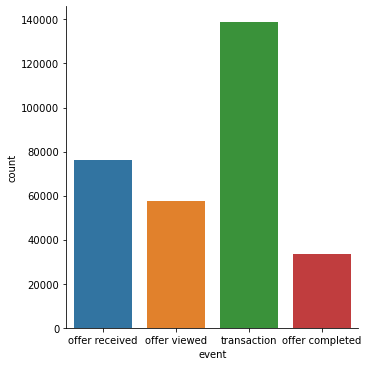

In [50]:
sns.catplot(x='event', kind="count", data=transcript)

### The above exploration shows the following:
- The dataset has no missing values nor duplicates.
- In the dataset we have 17000 unique costomers.
- There are four types of `events` (offer received, offer viewed, offer completed, transaction)

## Transcript: Data Preprocessing
- Rename person column to customer_id
- Rename time column to time_h to represent the feature unit.
- Match the avilable customer in the profile dataset with the one in transcript.
- Extract `value` column values into different columns.
- Drop `value` column after the extraction.
- Drop transaction rows since I'm only interested in only (offer completed, offer viewed).
- One hot encoding `event` column.
- Show the cleaned dataset.

In [51]:
# Reanme person column 
transcript.rename({'person': 'customer_id'}, axis=1, inplace= True)

In [52]:
# Remove customer id's that are not in the customer profile DataFrame
transcript = transcript[transcript['customer_id'].isin(profile['customer_id'])]

In [53]:
# Unpack the dict values so that each value will be represent in separate column
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)

In [54]:
# clean up the duplicates in offer id and offer_id and meger into one column
transcript['clean_id'] = np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(), transcript['offer_id'],transcript['offer id'])

# drop the original id columns
transcript.drop(['offer id', 'offer_id'], axis=1, inplace=True)

# rename the offer_id column
transcript.rename(columns={'clean_id': 'offer_id'}, inplace=True)

In [55]:
# drop value column
transcript.drop('value', axis=1, inplace=True)

In [56]:
# Drop offer recevied rows, since I'm only interested in offer viewed and completed
transcript.drop(transcript[transcript['event']=='offer received'].index, inplace=True,axis=0)

In [57]:
# Drop transaction rows
transcript.drop(transcript[transcript['event']== 'transaction'].index,axis=0,inplace = True)

In [58]:
# One hot encoding to event column
transcript['event'] = transcript['event'].apply(lambda x: 0 if 'offer viewed' in x else 1)

In [59]:
# Drop amount and reward columns since they have a huage number of missing valuse
transcript.drop('amount', axis=1, inplace=True)
transcript.drop('reward', axis=1, inplace=True)

In [60]:
transcript.rename({'time':'time_h'}, axis=1, inplace=True)

In [61]:
# Cleaned transcript Dataset
transcript.head()

,customer_id,event,time_h,offer_id
12650,389bc3fa690240e798340f5a15918d5c,0,0,f19421c1d4aa40978ebb69ca19b0e20d
12651,d1ede868e29245ea91818a903fec04c6,0,0,5a8bc65990b245e5a138643cd4eb9837
12652,102e9454054946fda62242d2e176fdce,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,02c083884c7d45b39cc68e1314fec56c,0,0,ae264e3637204a6fb9bb56bc8210ddfd
12655,be8a5d1981a2458d90b255ddc7e0d174,0,0,5a8bc65990b245e5a138643cd4eb9837


## Merging the three cleaned datasets

In [62]:
portfolio.head()

,reward,difficulty,duration_h,offer_type,offer_id,web,email,mobile,social
0,10,10,168,0,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,120,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,96,1,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,168,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,240,2,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


In [63]:
profile.head()

,gender,age,customer_id,became_member_on,income
1,2,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,2,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,1,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,1,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,1,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


In [64]:
transcript.head()

,customer_id,event,time_h,offer_id
12650,389bc3fa690240e798340f5a15918d5c,0,0,f19421c1d4aa40978ebb69ca19b0e20d
12651,d1ede868e29245ea91818a903fec04c6,0,0,5a8bc65990b245e5a138643cd4eb9837
12652,102e9454054946fda62242d2e176fdce,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,02c083884c7d45b39cc68e1314fec56c,0,0,ae264e3637204a6fb9bb56bc8210ddfd
12655,be8a5d1981a2458d90b255ddc7e0d174,0,0,5a8bc65990b245e5a138643cd4eb9837


In [65]:
# Merge the transcript and portfolio datasets
master_df = transcript.merge(portfolio,how='left',on='offer_id')

In [66]:
# Merge the master_df and profile datasets
master_df = master_df.merge(profile,how='left', on ='customer_id')

In [67]:
master_df.head()

,customer_id,event,time_h,offer_id,reward,difficulty,duration_h,offer_type,web,email,mobile,social,gender,age,became_member_on,income
0,389bc3fa690240e798340f5a15918d5c,0,0,f19421c1d4aa40978ebb69ca19b0e20d,5,5,120,0,1,1,1,1,1,65,2018-02-09,53000.0
1,d1ede868e29245ea91818a903fec04c6,0,0,5a8bc65990b245e5a138643cd4eb9837,0,0,72,1,0,1,1,1,0,53,2017-09-16,52000.0
2,102e9454054946fda62242d2e176fdce,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,120,0,1,1,1,1,2,69,2016-08-14,57000.0
3,02c083884c7d45b39cc68e1314fec56c,0,0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,168,0,0,1,1,1,2,20,2016-07-11,30000.0
4,be8a5d1981a2458d90b255ddc7e0d174,0,0,5a8bc65990b245e5a138643cd4eb9837,0,0,72,1,0,1,1,1,1,39,2014-05-27,51000.0


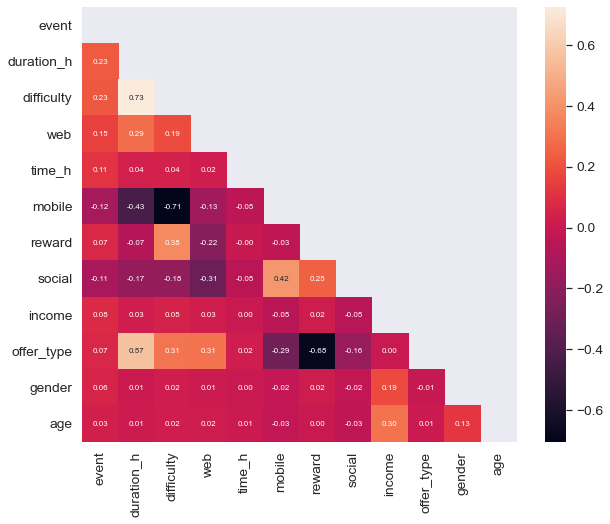

In [68]:
# Event correlation matrix
k = 17 #number of variables for heatmap
corrmat = abs(master_df.corr(method='spearman'))
# nlargest : Return this many descending sorted values
cols = corrmat.nlargest(k, 'event').index
cm = np.corrcoef(master_df[cols].values.T) 
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(10, 8))

# Hide upper symmetric metrics
mask = np.zeros_like(cm) 
mask[np.triu_indices_from(mask)] = True 
sns.set_style("white")
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                 annot_kws={'size': 8}, yticklabels=cols.values, 
                 xticklabels=cols.values, mask = mask)
plt.show()

# Part 3: Model Implementation & Evaluation

After I've finished preparing the data, I'll begin implementing models to determine which factors have the greatest impact on whether or not the client will respond to the offer.


As a result, I'll create models to forecast whether or not the consumer will respond to the offer using the 'event' feature as my target.
I'll also select various models in order to obtain more results, which will assist me in obtaining a more accurate model.


Because the goal of the project is to create a classification model, I chose accuracy and F1 score as model evaluation metrics. 

In [69]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82304 entries, 0 to 82303
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       82304 non-null  object        
 1   event             82304 non-null  int64         
 2   time_h            82304 non-null  int64         
 3   offer_id          82304 non-null  object        
 4   reward            82304 non-null  int64         
 5   difficulty        82304 non-null  int64         
 6   duration_h        82304 non-null  int64         
 7   offer_type        82304 non-null  int64         
 8   web               82304 non-null  int64         
 9   email             82304 non-null  int64         
 10  mobile            82304 non-null  int64         
 11  social            82304 non-null  int64         
 12  gender            82304 non-null  int64         
 13  age               82304 non-null  int64         
 14  became_member_on  8230

In [70]:
master_df.columns

Index(['customer_id', 'event', 'time_h', 'offer_id', 'reward', 'difficulty',
       'duration_h', 'offer_type', 'web', 'email', 'mobile', 'social',
       'gender', 'age', 'became_member_on', 'income'],
      dtype='object')

Split data into features and target labels, considering ONLY those features that I believe are important for my model to predict accurately.

Those features are as follows:

    time_h
    reward
    difficulty
    duration_h
    offer_type
    gender_F
    gender_M
    gender_O
    age
    income

Our target is:

    'event' that will be either:
        1 : offer completed
        0 : offer viewed



In [71]:
# Selecting features and target values
X = master_df[['time_h','offer_type','difficulty','duration_h','gender','age','income']]
Y = master_df['event']

In [72]:
# Normalizing some numerical values 
scaler = MinMaxScaler()
features = ['time_h','duration_h', 'difficulty']
X_scaled = X.copy()
X_scaled[features] = scaler.fit_transform(X_scaled[features])
X_scaled.head()

,time_h,offer_type,difficulty,duration_h,gender,age,income
0,0.0,0,0.25,0.285714,1,65,53000.0
1,0.0,1,0.00,0.000000,0,53,52000.0
2,0.0,0,0.50,0.285714,2,69,57000.0
3,0.0,0,0.50,0.571429,2,20,30000.0
4,0.0,1,0.00,0.000000,1,39,51000.0


In [73]:
# Creating training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [74]:
#Decision Tree Model
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print(f'Accuracy of Decision Tree classifier on training set: {round(dt.score(X_train, y_train)*100,2)}%')
print(f'Testing Accuracy: {round((dt.score(X_test, y_test)*100),2)}%')

y_pred_dt = dt.predict(X_train)

DecisionTreeClassifier_predictor_accuracy = accuracy_score(y_train, y_pred_dt)
DecisionTreeClassifier_predictor_f1score = f1_score(y_train, y_pred_dt)

print("Decision Tree Classifier predictor accuracy: %.3f" % (DecisionTreeClassifier_predictor_accuracy))
print("Decision Tree Classifier predictor f1-score: %.3f" % (DecisionTreeClassifier_predictor_f1score))



Accuracy of Decision Tree classifier on training set: 97.41%
Testing Accuracy: 59.27%
Decision Tree Classifier predictor accuracy: 0.974
Decision Tree Classifier predictor f1-score: 0.966


In [75]:
#Support Vector Machine Model

svm = SVC(gamma = 'auto')

svm.fit(X_train, y_train)
print(f'Accuracy of SVM classifier on training set: {round(svm.score(X_train, y_train)*100,2)}%')
print(f'Testing Accuracy: {round((svm.score(X_test, y_test)*100),2)}%')

y_pred_svm = svm.predict(X_train)

SVM_predictor_accuracy = accuracy_score(y_train, y_pred_svm)
SVM_predictor_f1score = f1_score(y_train, y_pred_svm)

print("Support Vector Machine predictor accuracy: %.3f" % (SVM_predictor_accuracy))
print("Support Vector Machine predictor f1-score: %.3f" % (SVM_predictor_f1score))



Accuracy of SVM classifier on training set: 96.49%
Testing Accuracy: 58.59%
Support Vector Machine predictor accuracy: 0.965
Support Vector Machine predictor f1-score: 0.953


In [76]:
#Naive Bayes Model

gnb = GaussianNB() 

gnb.fit(X_train, y_train) 
print(f'Accuracy of Naive Bayes on training set: {round(gnb.score(X_train, y_train)*100,2)}%')
print(f'Testing Accuracy: {round((gnb.score(X_test, y_test)*100),2)}%')

y_pred_gnb = gnb.predict(X_train)

NB_predictor_accuracy = accuracy_score(y_train, y_pred_gnb)
NB_predictor_f1score = f1_score(y_train, y_pred_gnb)

print("Naive Bayes predictor accuracy: %.3f" % (NB_predictor_accuracy))
print("Naive Bayes predictor f1-score: %.3f" % (NB_predictor_f1score))


Accuracy of Naive Bayes on training set: 61.54%
Testing Accuracy: 61.41%
Naive Bayes predictor accuracy: 0.615
Naive Bayes predictor f1-score: 0.476


In [77]:
#K-Nearest Neighbors Model

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
print(f'Accuracy of KNN classifier on training set: {round(knn.score(X_train, y_train)*100,2)}%')
print(f'Testing Accuracy: {round((knn.score(X_test, y_test)*100),2)}%')

y_pred_knn = knn.predict(X_train)

KNN_predictor_accuracy = accuracy_score(y_train, y_pred_knn)
KNN_predictor_f1score = f1_score(y_train, y_pred_knn)

print("KNeighbors Classifier predictor accuracy: %.3f" % (KNN_predictor_accuracy))
print("KNeighbors Classifier predictor f1-score: %.3f" % (KNN_predictor_f1score))



Accuracy of KNN classifier on training set: 74.68%
Testing Accuracy: 61.99%
KNeighbors Classifier predictor accuracy: 0.747
KNeighbors Classifier predictor f1-score: 0.657


In [78]:
#LogisticRegression Model 
logreg = LogisticRegression()

logreg.fit(X_train, y_train)
print(f'Accuracy of Logistic regression classifier on training set: {round(logreg.score(X_train, y_train)*100,2)}%')
print(f'Testing Accuracy: {round((logreg.score(X_test, y_test)*100),2)}%')

y_pred_logreg = logreg.predict(X_train)

LogisticRegression_predictor_accuracy = accuracy_score(y_train, y_pred_logreg)
LogisticRegression_predictor_f1score = f1_score(y_train, y_pred_logreg)

print("Logistic Regression Classifier predictor accuracy: %.3f" % (LogisticRegression_predictor_accuracy))
print("Logistic Regression Classifier predictor f1-score: %.3f" % (LogisticRegression_predictor_f1score))

Accuracy of Logistic regression classifier on training set: 59.33%
Testing Accuracy: 59.33%
Logistic Regression Classifier predictor accuracy: 0.593
Logistic Regression Classifier predictor f1-score: 0.273


We can observe from the results that Decision Tree's F1 performs somewhat better than the remining models.

However, the models' overall higher accuracy compared to the F1 score implies that it is better at predicting positive situations than negative cases, which is to be expected given the unbalanced classifications. 

# Part 4: API_Packaging 

This part is available in `train_save_model` and `model_API` files.

## Justification
I worked on the provided datasets by Starbucks for this project and then built a model that can predict whether a consumer will finish or browse the offer?


To begin, I looked at each dataset and visualized it to gain a better grasp of the data.
Then I moved on to the Preprocessing Section, which consumed the majority of my time and work.
After that, I experimented with many models to find which one worked best in this situation. 

I got the following insights from the datasets:
- The most popular offers are BOGO and discount.
- When compared to O, F & M have the highest revenue.
- The duration of the offer and the level of difficulty are the most correlated elements to the target feature. 

## Reflection & Improvement

I had a lot of fun working on this capstone project because it allowed me to improve my data preprocessing and modeling skills.
Preprocessing was, in my opinion, the most challenging portion.


Models could also be created to solve the following statemetns related with this data set:

- Creating a model that predicts which offers should be sent to which customers?

- Creating a model that can predict which clients will purchase in every situation 